<a href="https://colab.research.google.com/github/Veronika2311/ML_CL_HSE/blob/main/HW_7_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gdown
!gdown 1UOkVCCYuMRwdcuZwb0fNr_9t00-r1I6o

Downloading...
From: https://drive.google.com/uc?id=1UOkVCCYuMRwdcuZwb0fNr_9t00-r1I6o
To: /content/winemag-data-130k-v2.csv
100% 52.9M/52.9M [00:00<00:00, 90.0MB/s]


In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.corpus import stopwords

In [77]:
all_data = pd.read_csv('winemag-data-130k-v2.csv')
print(all_data.shape)

all_data.head(3)

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [7]:
!pip install pandas_profiling
import pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas_profiling-3.6.6-py2.py3-none-any.whl (324 kB)
  Using cached ydata_profiling-4.2.0-py2.py3-none-any.whl (352 kB)
  Using cached visions-0.7.5-py3-none-any.whl (102 kB)
  Using cached phik-0.12.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (679 kB)
  Using cached multimethod-1.9.1-py3-none-any.whl (10 kB)
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)
  Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (455 kB)
  Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.8.2.2
    Uninstalling wordcloud-1.8.2.2:
      Successfully uninstalled wordcloud-1.8.2.2


<ipython-input-7-303b0fc56fa5>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [8]:
#считается за визуализацию?
all_data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Давайте обратим своё внимание на колонки Country, description, points, province, variety и winery. В них почти нет NAN, а это значит, что наша кластеризация не собъётся в кучу по причине "заметили наны средними значениями и вот". Кроме того, это это позволит не удалять большое количество строк из датасета.

In [78]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [79]:
data = all_data[['country', 'description', 'points', 'province', 'variety', 'winery']]

In [80]:
data

,country,description,points,province,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,Mosel,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,Oregon,Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,Alsace,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,Alsace,Pinot Gris,Domaine Marcel Deiss


In [81]:
print(data.shape)
data = data.dropna()
data.shape

(129971, 6)


(129907, 6)

In [82]:
data["text"] = data.description.apply(lambda x: x.lower().split())

<ipython-input-82-0ce4eddf36f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data.description.apply(lambda x: x.lower().split())


In [85]:
input_text = list(data.text.values)

In [86]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['soft,', 'supple', 'plum', 'envelopes', 'an', 'oaky', 'structure', 'in', 'this', 'cabernet,', 'supported', 'by', '15%', 'merlot.', 'coffee', 'and', 'chocolate', 'complete', 'the', 'picture,', 'finishing', 'strong', 'at', 'the', 'end,', 'resulting', 'in', 'a', 'value-priced', 'wine', 'of', 'attractive', 'flavor', 'and', 'immediate', 'accessibility.'], tags=[10]),
 TaggedDocument(words=['this', 'is', 'a', 'dry', 'wine,', 'very', 'spicy,', 'with', 'a', 'tight,', 'taut', 'texture', 'and', 'strongly', 'mineral', 'character', 'layered', 'with', 'citrus', 'as', 'well', 'as', 'pepper.', "it's", 'a', 'food', 'wine', 'with', 'its', 'almost', 'crisp', 'aftertaste.'], tags=[11])]

In [24]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=8)

In [25]:
model.save("D2V.model")

In [87]:
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)
split_df = pd.DataFrame(vectors,
                        columns=['v'+str(i) for i in range(1,6)])

split_df

,v1,v2,v3,v4,v5
0,0.076777,0.176429,-0.210022,0.009010,-0.050981
1,-0.141329,0.158592,0.430205,-0.521889,0.014178
2,0.103791,0.346873,-0.045932,-0.264129,0.014568
3,-0.082329,0.174973,0.478734,-0.321631,0.047785
4,0.080916,0.132148,0.244356,-0.178836,0.039742
...,...,...,...,...,...
129902,-0.059048,-0.004461,0.197811,-0.049994,0.430903
129903,0.092207,0.241333,-0.074952,-0.252082,-0.103316
129904,0.034414,0.010500,0.162722,-0.255672,-0.134798
129905,0.012727,0.355934,0.387216,-0.011747,0.030677


In [88]:
data.reset_index(inplace=True)

In [89]:
result = data.join(split_df, how='left')
result.shape

(129907, 13)

In [90]:
data.isna().any()

index          False
country        False
description    False
points         False
province       False
variety        False
winery         False
text           False
dtype: bool

In [91]:
result.drop(['description', 'text'], axis=1)

,index,country,points,province,variety,winery,v1,v2,v3,v4,v5
0,0,Italy,87,Sicily & Sardinia,White Blend,Nicosia,0.076777,0.176429,-0.210022,0.009010,-0.050981
1,1,Portugal,87,Douro,Portuguese Red,Quinta dos Avidagos,-0.141329,0.158592,0.430205,-0.521889,0.014178
2,2,US,87,Oregon,Pinot Gris,Rainstorm,0.103791,0.346873,-0.045932,-0.264129,0.014568
3,3,US,87,Michigan,Riesling,St. Julian,-0.082329,0.174973,0.478734,-0.321631,0.047785
4,4,US,87,Oregon,Pinot Noir,Sweet Cheeks,0.080916,0.132148,0.244356,-0.178836,0.039742
...,...,...,...,...,...,...,...,...,...,...,...
129902,129966,Germany,90,Mosel,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),-0.059048,-0.004461,0.197811,-0.049994,0.430903
129903,129967,US,90,Oregon,Pinot Noir,Citation,0.092207,0.241333,-0.074952,-0.252082,-0.103316
129904,129968,France,90,Alsace,Gewürztraminer,Domaine Gresser,0.034414,0.010500,0.162722,-0.255672,-0.134798
129905,129969,France,90,Alsace,Pinot Gris,Domaine Marcel Deiss,0.012727,0.355934,0.387216,-0.011747,0.030677


In [92]:
one_hot = pd.get_dummies(data['country'])
result = result.join(one_hot, how='left')
one_hot = pd.get_dummies(data['province'])
result = result.join(one_hot, how='left', rsuffix='_right')
one_hot = pd.get_dummies(data['variety'])
result = result.join(one_hot, how='left', rsuffix='_right')

In [94]:
result = result.drop(['country', 'province', 'variety', 'winery', 'description', 'text'], axis=1)

In [96]:
result = result.drop('index', axis=1)

In [97]:
result

,points,v1,v2,v3,v4,v5,Argentina,Armenia,Australia,Austria,...,Yapincak,Zelen,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
0,87,0.076777,0.176429,-0.210022,0.009010,-0.050981,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87,-0.141329,0.158592,0.430205,-0.521889,0.014178,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87,0.103791,0.346873,-0.045932,-0.264129,0.014568,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87,-0.082329,0.174973,0.478734,-0.321631,0.047785,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87,0.080916,0.132148,0.244356,-0.178836,0.039742,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129902,90,-0.059048,-0.004461,0.197811,-0.049994,0.430903,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129903,90,0.092207,0.241333,-0.074952,-0.252082,-0.103316,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129904,90,0.034414,0.010500,0.162722,-0.255672,-0.134798,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129905,90,0.012727,0.355934,0.387216,-0.011747,0.030677,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ура, переходим к кластеризации
---
Только сначала лучше выделить главные компоненты


In [98]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)

pca_2_result = pca_2.fit_transform(result)

pca_2_result.shape

(129907, 2)

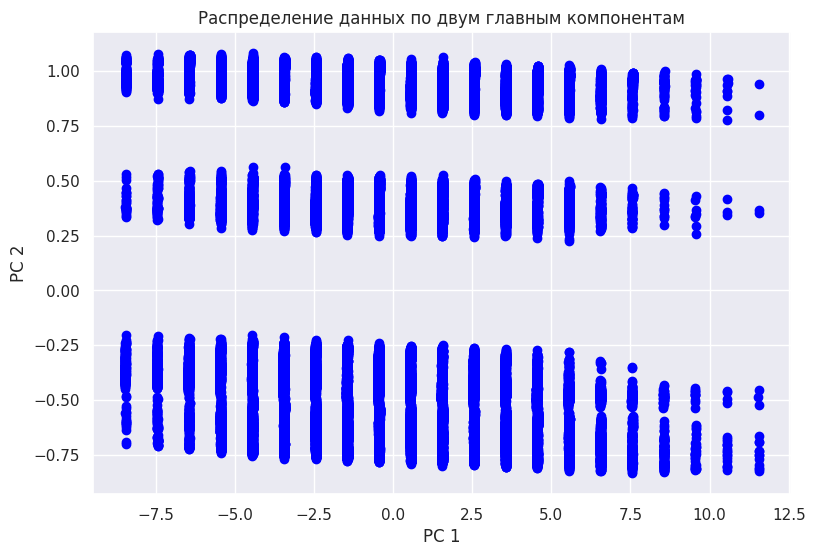

In [99]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Вероятнее всего, повлияло то, что куча наших данных -- категориальные, а не числовые

In [100]:
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from tqdm import tqdm

inertia = []
silhouette = []
for i in tqdm(range(2,20)):

    kmeans = cluster.KMeans(
               n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=42
    )


    kmeans.fit(pca_2_result)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

 28%|██▊       | 5/18 [24:53<1:04:41, 298.60s/it]


KeyboardInterrupt: ignored

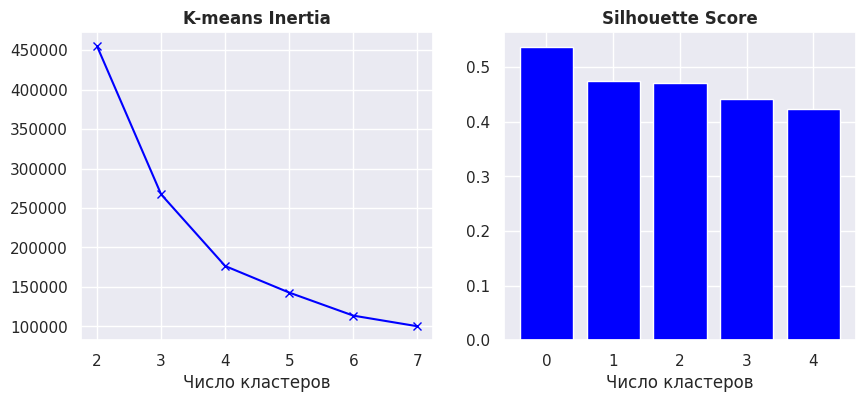

In [101]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), silhouette, align='center',color= 'blue')
plt.xticks(range(len(silhouette)), range(len(silhouette))) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

In [102]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(min_samples=2, eps=0.5)
cluster.fit(pca_2_result)

DBSCAN(min_samples=2)

In [103]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(pca_2_result, cluster.labels_ ))

Silhouette Coefficient: 0.553
